# Module 3 Project - Whisky Sommelier
# EDA and Feature Engineering
By: **Maura Cerow**, **Rajeev Panwar** and **Bryan Santos**

This project aims to build the first module of a comprehensive whisky recommendation engine, an **automated whisky sommelier**. We would like this to act as a go-to "middle-man" between distributors, bars and consumers.

This notebook in particular handles the EDA and resulting feature engineering. The source is https://www.distiller.com.

## Dataset

After data cleaning, we have retained a total of 2,622 observations in our dataset. The following are our target and feature variables. We still plan to add some new predictors based on the resulting EDA and feature interactions. 

**Target**  
- Whisky's country of origin: 
    - Scotland
    - Japan
    - USA
    - Canada
    - Ireland

**Features**
- Type (whether it is Single Malt, Blended, Rye, etc.)
- Price (ranging from 1 to 5 with 5 being the most expensive)
- Expert Score (critic score)
- User Rating (distiller.com user reviews)
- ABV (Alcohol By Volume)
- Description
- Style (ingredients)
- Maturing/Cask (whether matured in Oak, Sherry, etc.)
- Flavor Profiles (each having intensity scores ranging from 0 to 100):
    - *Smoky*
    - *Peaty*
    - *Spicy*
    - *Herbal*
    - *Oily*
    - *Full-Bodied*
    - *Rich*
    - *Sweet*
    - *Briny*
    - *Salty*
    - *Vanilla*
    - *Tart*
    - *Fruity*
    - *Floral*

## Package Imports and Data Load

In [537]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno

sns.set()
%matplotlib inline

### Suppress notebook warnings ###
import warnings
warnings.filterwarnings('ignore')

### Pandas settings to avoid exponential form and display all columns ###
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

In [538]:
df = pd.read_csv("whisky_df_clean.csv", sep=',')

In [539]:
df.head(5)

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
0,Hibiki 21 Year,Blended,5,99,4.520,Hibiki is the blended whisky brand produced by...,43.000,Comprised of both single malt(s) and single gr...,"ex-bourbon American oak, ex-sherry European oa...","""Tasting this whisky was one of those moments ...",30,30,50,30,20,80,80,85,0,15,20,25,85,50,4
1,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,ex-sherry,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0
2,George T. Stagg Bourbon (Fall 2019),Bourbon,4,98,4.590,George T. Stagg Bourbon (Fall 2019) is an uncu...,58.450,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak","""Lots of oak shows up on the nose along with c...",40,40,65,50,20,60,60,45,0,0,60,60,45,0,1
3,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,"ex-bourbon, ex-sherry, new Mizunara oak","""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0
4,The Macallan M,Single Malt,5,98,4.190,A 6-litre Lalique decanter of this single malt...,47.700,Distilled in pot stills from 100% malted barle...,sherry oak casks,"""The aroma is that pleasing bouquet that comes...",50,50,60,0,15,90,100,50,0,0,20,20,80,10,0


## EDA

### Target variable - country of origin

In [540]:
df['country'].value_counts()

1    1192
0    1032
2     175
3     152
4     111
Name: country, dtype: int64

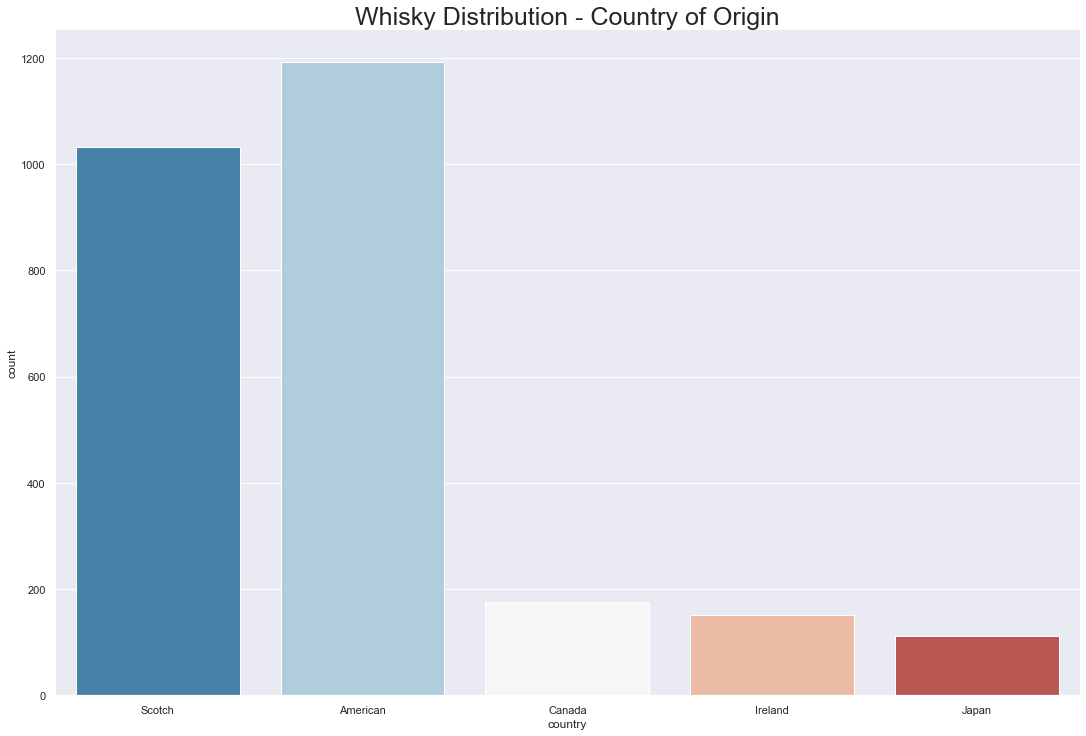

In [541]:
ax = sns.catplot(x="country", kind="count", palette="RdBu_r", data=df, height=10, aspect=15/10)
ax.set(xticklabels=['Scotch', 'American', 'Canada', 'Ireland', 'Japan'])
sns.set(font_scale=2)

plt.title('Whisky Distribution - Country of Origin', {'fontsize': 25})
plt.show()

Based on the value counts and on the graph above, there is indeed class imbalance. Scotch and American whiskies comprise majority of the observations in the dataset. To avoid class imbalance leading to inaccurate models and predictions, we will handle the imbalance later on using various techniques. Then we will compare the scores against models without imbalance handling to see if they are effective.

### Handling missing numeric values

In [542]:
df.describe()

,price,expert_score,user_rating,abv,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
count,2662.000,2662.000,2587.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000,2662.000
mean,3.058,86.391,3.740,46.892,23.643,23.643,46.235,26.002,29.515,54.434,54.526,55.985,9.080,10.597,43.807,24.030,44.886,22.643,0.917
std,1.158,5.895,0.569,6.345,21.067,21.067,20.849,19.499,20.115,18.848,19.436,18.721,15.579,15.632,20.689,18.657,23.127,20.548,1.025
min,1.000,40.000,0.000,30.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.000,83.000,3.420,43.000,10.000,10.000,30.000,10.000,15.000,40.000,40.000,40.000,0.000,0.000,30.000,10.000,25.000,10.000,0.000
50%,3.000,87.000,3.760,46.000,20.000,20.000,50.000,20.000,30.000,55.000,60.000,60.000,0.000,5.000,40.000,20.000,40.000,20.000,1.000
75%,4.000,90.000,4.140,50.000,35.000,35.000,60.000,40.000,40.000,70.000,70.000,70.000,10.000,17.000,60.000,40.000,65.000,30.000,1.000
max,5.000,99.000,5.000,80.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,90.000,100.000,90.000,100.000,90.000,4.000


It seems only user rating has missing values based on our observation above. But there might be more to it than what meets the eye. Some user rating has a value of 0.00 which means it should have been null. 

The first step to address this is to convert all 0.00 values into nan. 

In [543]:
df.loc[df["user_rating"] == 0.000, "user_rating"] = np.NAN

A better way to analyze missing values is by drawing a nullity matrix.

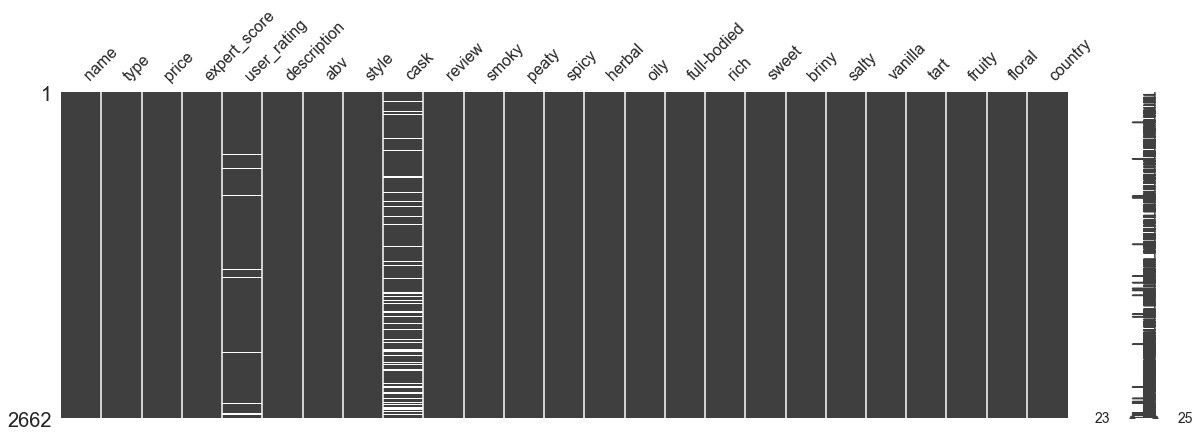

In [544]:
mno.matrix(df, figsize = (20, 6))
plt.show()

We also see that cask has missing values but since it is not yet numeric, we will deal with this later. Let us deal with user rating first using *imputation based on another semi-related variable*.

**Expert scores** and **user ratings** are both subjective quantitative review assessment of each whisky. The plan is to compute for the missing user ratings based on the expert score because we have complete expert score values. We will divide the expert score mean over user rating mean to get the weight of expert score in terms of user rating. To get the missing user rating, we will divide its expert score over the weight.



In [545]:
### Compure for the standard weight of expert scores against user ratings ###
weight = df['expert_score'].mean() / df['user_rating'].mean()

In [546]:
### Impute weighted user score if value is missing ###
df['user_rating'] = df.apply(
    lambda row: row['expert_score'] / weight if np.isnan(row['user_rating']) else row['user_rating'],
    axis=1
)

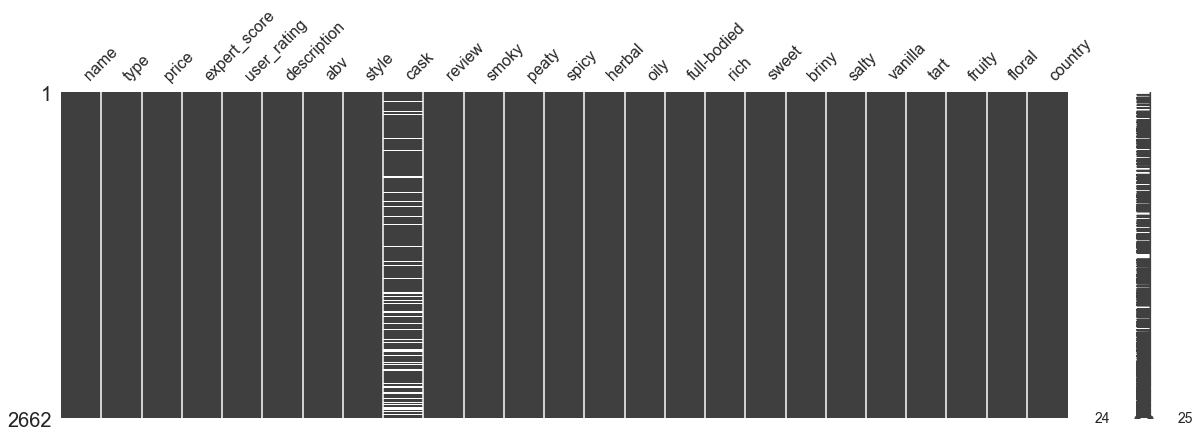

In [547]:
### Validate result ###
mno.matrix(df, figsize = (20, 6))
plt.show()

### Flavor profiles

In [548]:
df.columns

Index(['name', 'type', 'price', 'expert_score', 'user_rating', 'description',
       'abv', 'style', 'cask', 'review', 'smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral', 'country'],
      dtype='object')

In [549]:
### Create a df of only the flavor profiles ###
flavor_df = df[['smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral']]

In [550]:
### Check correlation ###
flavor_df.corr()

,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
smoky,1.000,1.000,0.208,0.192,0.206,0.192,0.171,-0.069,0.441,0.407,0.072,0.126,0.063,0.044
peaty,1.000,1.000,0.208,0.192,0.206,0.192,0.171,-0.069,0.441,0.407,0.072,0.126,0.063,0.044
spicy,0.208,0.208,1.000,0.426,0.276,0.277,0.250,0.114,0.047,0.116,0.354,0.280,0.203,0.202
herbal,0.192,0.192,0.426,1.000,0.335,0.085,0.076,0.035,0.174,0.209,0.244,0.357,0.179,0.380
oily,0.206,0.206,0.276,0.335,1.000,0.305,0.279,0.113,0.306,0.318,0.289,0.260,0.203,0.269
full-bodied,0.192,0.192,0.277,0.085,0.305,1.000,0.844,0.436,0.123,0.183,0.303,0.066,0.233,0.084
rich,0.171,0.171,0.250,0.076,0.279,0.844,1.000,0.475,0.097,0.152,0.325,0.072,0.279,0.129
sweet,-0.069,-0.069,0.114,0.035,0.113,0.436,0.475,1.000,-0.051,0.049,0.477,0.119,0.446,0.257
briny,0.441,0.441,0.047,0.174,0.306,0.123,0.097,-0.051,1.000,0.781,0.013,0.139,0.107,0.153
salty,0.407,0.407,0.116,0.209,0.318,0.183,0.152,0.049,0.781,1.000,0.115,0.176,0.208,0.215


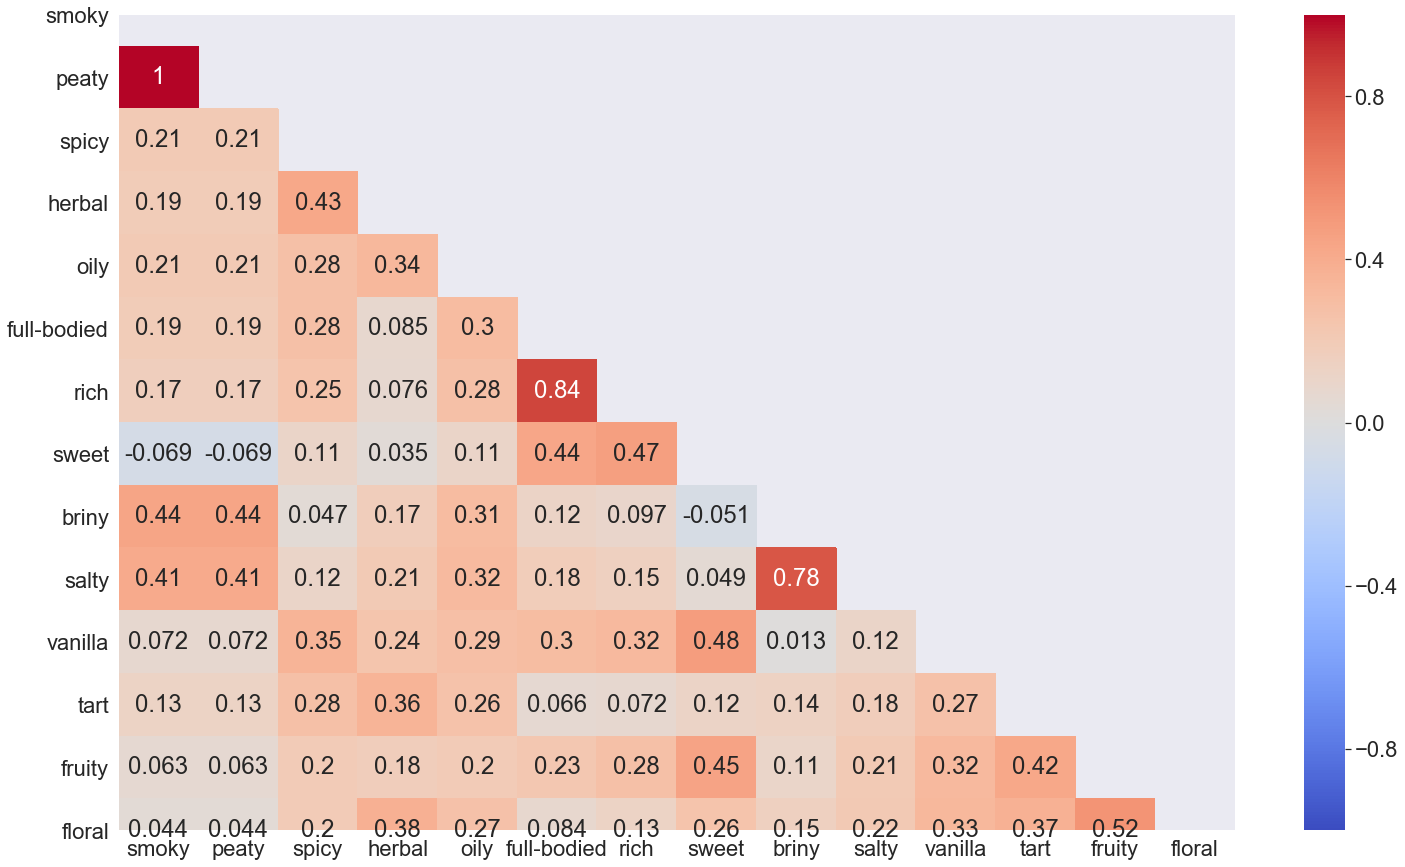

In [551]:
### Plot correlation between flavor profiles ###

f, ax = plt.subplots(figsize=(25, 15))
matrix = np.triu(flavor_df.corr())
sns.heatmap(flavor_df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)
plt.show()

# Handling Missing Cask Values

We have null values in our Cask column. Different casks offer different flavors and we believe the cask is indicative of type of whiksy we're trying to predict. 

In [552]:
df.head()

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
0,Hibiki 21 Year,Blended,5,99,4.520,Hibiki is the blended whisky brand produced by...,43.000,Comprised of both single malt(s) and single gr...,"ex-bourbon American oak, ex-sherry European oa...","""Tasting this whisky was one of those moments ...",30,30,50,30,20,80,80,85,0,15,20,25,85,50,4
1,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,ex-sherry,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0
2,George T. Stagg Bourbon (Fall 2019),Bourbon,4,98,4.590,George T. Stagg Bourbon (Fall 2019) is an uncu...,58.450,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak","""Lots of oak shows up on the nose along with c...",40,40,65,50,20,60,60,45,0,0,60,60,45,0,1
3,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,"ex-bourbon, ex-sherry, new Mizunara oak","""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0
4,The Macallan M,Single Malt,5,98,4.190,A 6-litre Lalique decanter of this single malt...,47.700,Distilled in pot stills from 100% malted barle...,sherry oak casks,"""The aroma is that pleasing bouquet that comes...",50,50,60,0,15,90,100,50,0,0,20,20,80,10,0


In [553]:
pd.set_option('display.max_rows', None)

In [554]:
### A lot of the style observations include the cask. The plan is to parse through the styles to pull out the cask
### details for each null value.

df['style'].iloc[0]

'Comprised of both single malt(s) and single grain(s) often from many different distilleries; if Scotch or Irish must be aged for at least three years in oak barrels; Irish may include single pot still whiskey in the blend.'

In [555]:
### identifying the number of null values we have.

df['cask'].isnull().sum()

449

In [556]:
### to make it easier to filter, changed the NA value to 'Fix'. We're hoping to fix all the missing values based on 
### what the style description tells us.

df['cask'] = df['cask'].fillna('Fix')
df.head()

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
0,Hibiki 21 Year,Blended,5,99,4.520,Hibiki is the blended whisky brand produced by...,43.000,Comprised of both single malt(s) and single gr...,"ex-bourbon American oak, ex-sherry European oa...","""Tasting this whisky was one of those moments ...",30,30,50,30,20,80,80,85,0,15,20,25,85,50,4
1,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,ex-sherry,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0
2,George T. Stagg Bourbon (Fall 2019),Bourbon,4,98,4.590,George T. Stagg Bourbon (Fall 2019) is an uncu...,58.450,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak","""Lots of oak shows up on the nose along with c...",40,40,65,50,20,60,60,45,0,0,60,60,45,0,1
3,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,"ex-bourbon, ex-sherry, new Mizunara oak","""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0
4,The Macallan M,Single Malt,5,98,4.190,A 6-litre Lalique decanter of this single malt...,47.700,Distilled in pot stills from 100% malted barle...,sherry oak casks,"""The aroma is that pleasing bouquet that comes...",50,50,60,0,15,90,100,50,0,0,20,20,80,10,0


In [557]:
### setting a new dataframe for our null values. this is just for reference to see just the observations we want to
### update

cask_nas = df[df['cask'] == 'Fix']
cask_nas.head()

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
21,Hibiki 30 Year,Blended,5,97,4.840,This blended whisky is comprised of single mal...,43.000,Comprised of both single malt(s) and single gr...,Fix,"""Orange marmalade, rich dark chocolate, and ap...",20,20,75,30,20,65,70,85,20,15,30,10,85,25,4
44,Hibiki 30 Year,Blended,5,97,4.840,This blended whisky is comprised of single mal...,43.000,Comprised of both single malt(s) and single gr...,Fix,"""Orange marmalade, rich dark chocolate, and ap...",20,20,75,30,20,65,70,85,20,15,30,10,85,25,4
46,Glenmorangie 1970's Collection '77,Single Malt,5,97,4.430,The 1977 entrant of the 1970s Collection was d...,43.000,Distilled in pot stills from 100% malted barle...,Fix,"""The nose begins dry, spicy and oaky, but a bu...",30,30,40,10,20,60,70,40,0,0,50,10,30,30,0
48,The Last Drop 48 Year Blended Scotch Whisky,Blended,5,97,4.580,This 48 Year blended whisky is the 4th release...,48.600,Comprised of both single malt(s) and single gr...,Fix,"""The nose bursts out at you from the glass, wi...",10,10,30,20,10,70,60,60,0,0,50,10,60,20,0
60,Mister Sam Blended Whiskey (2019 Release),Other Whiskey,5,96,4.850,Mister Sam Blended Whiskey is a limited releas...,66.900,A spirit distilled from a mash of grain(s) at ...,Fix,"""Drew Mayville juiced whisky from dynamite for...",60,60,55,20,35,65,65,45,0,0,45,20,55,25,2


In [558]:
cask_nas.shape

(449, 25)

In [559]:
cask_nas['style'].value_counts()

Distilled in pot stills from 100% malted barley, produced at one distillery, aged in barrels; if Scotch or Irish, must be aged for at least three years.                                                                                                                                                                            66
Comprised of both single malt(s) and single grain(s) often from many different distilleries; if Scotch or Irish must be aged for at least three years in oak barrels; Irish may include single pot still whiskey in the blend.                                                                                                      62
100% malted barley from a single distillery. Dried with peat.                                                                                                                                                                                                                                                                       54
DISTILLED IN CANADA

In [560]:
for i in df['cask']:
    if i is 'Fix':
        df.loc[((df['style'] == "Comprised of both single malt(s) and single grain(s) often from many different distilleries; if Scotch or Irish must be aged for at least three years in oak barrels; Irish may include single pot still whiskey in the blend.")) , 'cask'] = 'oak'
        df.loc[((df['style'] == "Mash bill at least 51% rye; aged in new, charred oak barrels.\n")) , 'cask'] = 'oak'
        df.loc[((df['style'] == "Mash bill at least 80% corn, no requirement to age, but if aged, must be in either new un-charred oak barrels or used oak barrels.")), 'cask'] == "oak"
        df.loc[((df['style'] == 'Produced anywhere in USA; Mash bill of at least 51% corn; aged in new, charred oak containers.\n')), 'cask'] == 'oak'
        df.loc[((df['style'] == "Mash bill at least 51% wheat; aged in new, charred oak barrels\n")), 'cask'] = 'oak'
        df.loc[((df['style'] == "Mash bill at least 80% corn, no requirement to age, but if aged, must be in either new un-charred oak barrels or used oak barrels.")) , 'cask'] = 'oak'
        df.loc[((df['style'] == "Produced in Tennessee; mash grain at least 51% corn; aged in new, charred oak barrels; filtered through maple charcoal prior to aging.")) , 'cask'] = 'oak'
        df.loc[((df['style'] == "Made in the USA from 100% malted barley. Distilled at one distillery. Matured in oak casks no larger than 700L. Distilled to no higher than 160 proof (80% ABV). Bottled at 80 proof (40% ABV) or higher. (This is the proposed Standard of Identity by the American Single Malt Whiskey Commission.)\n\n")) , 'cask'] = 'oak'
        
    else:
        continue

In [561]:
for i in df['cask']:
    if i is 'Fix':
        df.loc[((df['style'] == 'Produced anywhere in USA; Mash bill of at least 51% corn; aged in new, charred oak containers.\n')), 'cask'] = 'oak'
    
    else:
        continue

In [685]:
### goal is to have just the major casks - oak, bourbon, sherry, bourbon_sherry & other

### we have tons of observations that are the same, but entered differently. we want to standardize all the values to
### make sense of this feature

# first and foremost, make everything lowercase
df['cask'] = df['cask'].map(lambda x: str(x).lower())
# removing any punctuation and conjunctions
df['cask'] = df['cask'].map(lambda x: str(x).replace('&', ""))
df['cask'] = df['cask'].map(lambda x: str(x).replace(' and ', " "))
df['cask'] = df['cask'].map(lambda x: str(x).replace('-', " "))
df['cask'] = df['cask'].map(lambda x: str(x).replace('/', " "))
df['cask'] = df['cask'].map(lambda x: str(x).replace(',', ""))

In [686]:
df['cask_category'] = df['cask'].map(lambda x: str(x.split(" ")))

In [687]:
df['cask'].head(10)

0                                      oak
1                                ex sherry
2                                      oak
3    ex bourbon ex sherry new mizunara oak
4                         sherry oak casks
5        american oak refill european oak 
6                                      oak
7                                      oak
8                     ex bourbon ex sherry
9                                      oak
Name: cask, dtype: object

In [688]:
for i in range(len(df['cask_category'])):
#     counter = 0
    lst = df['cask_category'][i]
#     print(lst)
    if ('bourbon' in lst) and ('sherry' in lst):
        df['cask_category'][i] = 'bourbon_sherry'
    elif ('bourbon' in lst) and ('oak' in lst):
        df['cask_category'][i] = 'bourbon_oak'
    elif ('sherry' in lst) and ('oak' in lst):
        df['cask_category'][i] = 'sherry_oak'
    elif 'bourbon' in lst:
        df['cask_category'][i] = 'bourbon'
    elif 'sherry' in lst:
        df['cask_category'][i] = 'sherry'
    elif 'oak' in lst:
        df['cask_category'][i] = 'oak'
    else:
         df['cask_category'][i] = 'other'

print(df['cask_category'].head(10))
print(df['cask_category'].value_counts())

0               oak
1            sherry
2               oak
3    bourbon_sherry
4        sherry_oak
5               oak
6               oak
7               oak
8    bourbon_sherry
9               oak
Name: cask_category, dtype: object
oak               1404
other              456
bourbon            264
bourbon_sherry     221
sherry             143
bourbon_oak         89
sherry_oak          85
Name: cask_category, dtype: int64


In [631]:
lst = df['cask_category'][3]

if 'sherry' in lst:
    print('sherry')

sherry


In [400]:
df[df['style'] == '100% malted barley from a single distillery. Dried with peat.']

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country,455,505,1234,1277,1297,1442,2377
1,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,ex-sherry,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0,oak,oak,oak,oak,oak,oak,oak
3,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,"ex-bourbon, ex-sherry, new Mizunara oak","""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0,oak,oak,oak,oak,oak,oak,oak
5,Port Ellen 32 Year 1979 (2012 Special Release),Peated Single Malt,5,98,4.950,Port Ellen is one of those tragic casualties o...,52.500,100% malted barley from a single distillery. D...,"American oak, refill European oak","""The nose is surprisingly sweet and fruity, ye...",70,70,20,10,20,80,80,60,15,5,40,25,50,0,0,oak,oak,oak,oak,oak,oak,oak
16,Bunnahabhain 2008 Mòine Bordeaux Red Wine Cask...,Peated Single Malt,4,97,4.380,Bunnahabhain 2008 Mòine Bordeaux Red Wine Cask...,58.100,100% malted barley from a single distillery. D...,Bordeaux red wine casks,"""The aromas here bounce back and forth between...",90,90,80,40,60,100,90,60,30,30,40,10,60,10,0,oak,oak,oak,oak,oak,oak,oak
17,Bowmore Vintner's Trilogy 26 Year French Oak B...,Peated Single Malt,5,97,4.520,Released as part of Bowmore's Vintner's Trilog...,48.700,100% malted barley from a single distillery. D...,ex-bourbon & ex-red wine barriques,"""A 26 year-old scotch from Bowmore brings with...",65,65,40,20,60,80,80,60,25,10,45,20,25,10,0,oak,oak,oak,oak,oak,oak,oak
19,Ardbeg 17 Year,Peated Single Malt,5,97,4.240,"An ancient distillery, Ardbeg was founded in 1...",40.000,100% malted barley from a single distillery. D...,Ex-bourbon Barrels,"""The Ardbeg 17 starts smooth on the nose, low ...",65,65,10,15,15,5,20,65,55,45,70,0,5,15,0,oak,oak,oak,oak,oak,oak,oak
22,Laphroaig 32 Year,Peated Single Malt,5,97,4.740,2015 is the 200th anniversary of Laphroaig Dis...,46.700,100% malted barley from a single distillery. D...,ex-Oloroso sherry,"""Concentrated bursts of candied apples, dried ...",50,50,20,0,20,80,75,60,20,5,40,15,60,0,0,oak,oak,oak,oak,oak,oak,oak
24,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,ex-sherry,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0,oak,oak,oak,oak,oak,oak,oak
26,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,"ex-bourbon, ex-sherry, new Mizunara oak","""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0,oak,oak,oak,oak,oak,oak,oak
28,Port Ellen 32 Year 1979 (2012 Special Release),Peated Single Malt,5,98,4.950,Port Ellen is one of those tragic casualties o...,52.500,100% malted barley from a single distillery. D...,"American oak, refill European oak","""The nose is surprisingly sweet and fruity, ye...",70,70,20,10,20,80,80,60,15,5,40,25,50,0,0,oak,oak,oak,oak,oak,oak,oak
